In [1]:
import numpy as np
import torch
from torch import nn
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score

from dataset import CustomImageDataset

In [2]:
learning_rate = 1e-4
epochs = 500
batch_size = 16
dropout_prob=0.50

In [3]:
full_ds = CustomImageDataset(list(range(400)), load_embeddings=True)

In [4]:
from model import MLP
mlp = MLP(d_in=1024, d_hidden=128, d_out=4, dropout_prob=dropout_prob)
print(mlp)

MLP(
  (linear1): Linear(in_features=1024, out_features=128, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (linear2): Linear(in_features=128, out_features=4, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
)


In [5]:
from torch.utils.data import DataLoader


train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(full_ds, [0.7, 0.15, 0.15])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [6]:
#model training
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=learning_rate) 

train_losses = []
val_losses = []

for epoch in range(epochs):
    if epoch % 50==0:
        print(f'== epoch {epoch} ==')
    # Train the model
    mlp.train()
    train_loss = 0.0
    for i, (embedding, label) in enumerate(train_loader):
        optimizer.zero_grad()

        # Forward pass
        outputs =  mlp(embedding)
        loss = criterion(outputs, label)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * embedding.size(0)
    
    train_loss /= len(train_dataset)
    if epoch % 50==0:
        print(f"average train_loss : {train_loss}")

    mlp.eval()
    val_loss = 0.0
    for i, (embedding, label) in enumerate(val_loader):                 
        # Forward pass
        outputs =  mlp(embedding)
        loss = criterion(outputs, label)
        val_loss += loss.item() * embedding.size(0)
    val_loss /= len(val_dataset)
    if epoch % 50==0:
        print(f"average val_loss : {val_loss}")
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)


== epoch 0 ==


/home/aschieb/Desktop/interview/dataset.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  emb = torch.load(emb_path)


average train_loss : 1.3860673018864222
average val_loss : 1.3847429672876994
== epoch 50 ==
average train_loss : 1.1577830178397042
average val_loss : 1.142755659421285
== epoch 100 ==
average train_loss : 1.1008480548858643
average val_loss : 1.0691067218780517
== epoch 150 ==
average train_loss : 1.096025698525565
average val_loss : 1.028396213054657
== epoch 200 ==
average train_loss : 1.095619763646807
average val_loss : 1.0016106923421224
== epoch 250 ==
average train_loss : 1.0255207095827374
average val_loss : 0.9776834170023601
== epoch 300 ==
average train_loss : 1.0878257274627685
average val_loss : 0.9619862675666809
== epoch 350 ==
average train_loss : 1.0653366599764142
average val_loss : 0.9469333370526631
== epoch 400 ==
average train_loss : 1.105879204613822
average val_loss : 0.9339449365933736
== epoch 450 ==
average train_loss : 1.08534950869424
average val_loss : 0.9308441797892253


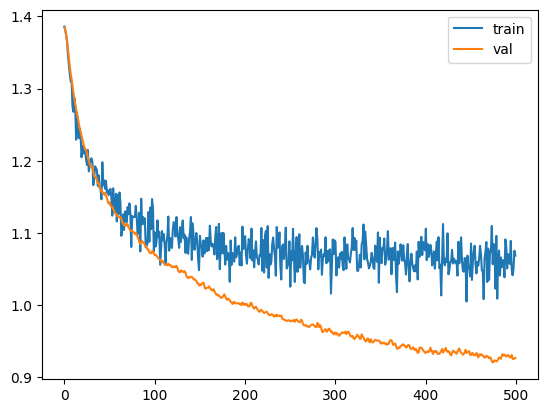

In [7]:
import matplotlib.pyplot as plt

plt.plot(list(range(epochs)), train_losses)
plt.plot(list(range(epochs)), val_losses)
plt.legend(['train','val'])
plt.show()


In [8]:
# Test model
mlp.eval()
preds = []
labels = []
for i, (embedding, label) in enumerate(test_dataset):
    p = mlp(embedding).flatten().detach().numpy()
    pred_class = np.argmax(p)
    label_class = np.argmax(label.detach().numpy())

    preds.append(pred_class)
    labels.append(label_class)

/home/aschieb/Desktop/interview/dataset.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  emb = torch.load(emb_path)


accuracy: 0.9


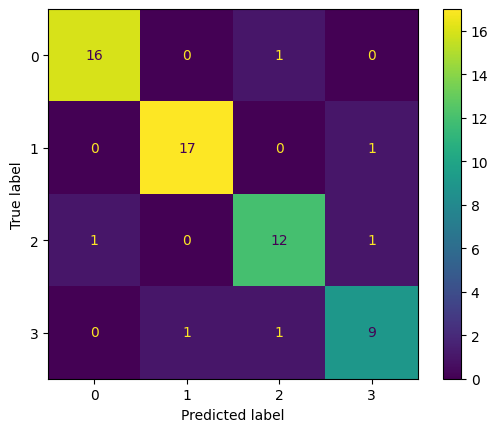

In [9]:
cm = confusion_matrix(labels, preds)
ConfusionMatrixDisplay(cm).plot()
print(f'accuracy: {accuracy_score(labels, preds)}')